In [1]:
# Import and setup:
import numpy as np
import scipy as sp
import csv
import matplotlib.pyplot as plt
import sys
import caffe
from image_handling import load_dataset
from image_handling import segment_image
from image_handling import preprocess_image
from image_handling import apply_depths
from image_handling import real_world_values
caffe.set_mode_gpu()

# --------------- Latex Plot Beautification --------------------------
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 12,
#           'text.fontsize': 10,
          'legend.fontsize': 10,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

%matplotlib inline
%load_ext autoreload
%autoreload 0

# big plots:
import matplotlib
default_dpi = matplotlib.rcParams['savefig.dpi']
if default_dpi == "figure":
    default_dpi = 360.0
matplotlib.rcParams['savefig.dpi'] = 2 * default_dpi


def load_csv(path):
    """ 
    returns a dict from a CSV of format:
        /a/abbey 0
        /a/airport_terminal 1
        /a/alley 2
        etc
    """
    f = open(path)
    csvf = csv.reader(f)
    labels = {}
    for row in csvf:
        tmp = row[0].split(' ',1)
        labels[int(tmp[1])] = tmp[0]
    f.close()
    
    return labels

# take an array of shape (n, height, width) or (n, height, width, channels)
#  and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)
def vis_square(data, padsize=1, padval=0):
    data -= data.min()
    data /= data.max()
    
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, padsize), (0, padsize)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant', constant_values=(padval, padval))
    
    # tile the filters into an image
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data)
    

# # Map from quantized bin values to linear depth    
# def bin_to_depth(vals, min_depth, max_depth,n_bins):
#     return min_depth*np.exp(vals*np.log(max_depth/min_depth)/(n_bins - 1))

In [2]:
# Instantiate classifier:
from depth_predictor import DepthPredictor

# bvlc reference:
modfile = 'models/bvlc_reference_caffenet/deploy.prototxt'
prefile = 'models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel'
#setmean = np.load('models/ilsvrc_2012_mean.npy')

# places CNN:
modfile = 'models/placesCNN/places205CNN_deploy.prototxt'
prefile = 'models/placesCNN/places205CNN_iter_300000.caffemodel'
#setmean = sp.io.loadmat('models/placesCNN/places_mean.mat')
#setmean = setmean['image_mean']
setmean = None
#labels =  load_csv('models/placesCNN/categoryIndex_places205.csv')

# Euclidean-Norm Regressor:
#prefile = 'models/unary_depth_regressor/snapshots_euclidean/udr_euclidean_dir_16_norm_iter_5000.caffemodel'
#modfile = 'models/unary_depth_regressor/udr_euclidean_deploy.prototxt'

# Euclidean-Norm Regressor (16 bins, zero-padded corners)
#prefile = 'models/unary_depth_regressor/snapshots_euclidean/udr_euclidean_dir_v3_16_norm_realmean_iter_20000.caffemodel'
#prefile ='models/unary_depth_regressor/snapshots_euclidean/udr_euclidean_dir_v3_16_superpixel_avg_iter_20000.caffemodel'
prefile ='models/unary_depth_regressor/snapshots_euclidean/udr_euclidean_d16_superpixel_avg_hardcoded_output_layer_iter_20000.caffemodel'
modfile = 'models/unary_depth_regressor/udr_euclidean_deploy.prototxt'
#modfile = 'models/unary_depth_regressor/udr_graphcut.prototxt'
meanfile = 'train/NYUv2/Mean.jpg'
setmean = caffe.io.load_image(meanfile)
# Euclidean-Norm Regressor(128,bins, zero-padded corners)
#prefile = 'models/unary_depth_regressor/snapshots_euclidean/udr_euclidean_dir_v3_128_norm_iter_2000.caffemodel'
#modfile = 'models/unary_depth_regressor/udr_euclidean_deploy.prototxt'

# Softmax Classifier:
#prefile = 'models/unary_depth_regressor/snapshots_softmax/udr_softmax_dir_16_norm_superpixel_avg_iter_40000.caffemodel'
#modfile = 'models/unary_depth_regressor/udr_softmax_deploy_2.prototxt'

#setmean = 'train/NYUv2/NYUv2_train_mean_full_167_resize_d16.binaryproto'

# Softmax Predictomatic:
#prefile = 'models/unary_depth_regressor/snapshots/udr_softmax_lmdb_167_snapshot_iter_3000.caffemodel'
#modfile = 'models/unary_depth_regressor/udr_softmax_deploy.prototxt'
# Instantiate
DP = DepthPredictor()
#DP2 = DepthPredictor()
# Load pre-trained model
DP.load(model_file=modfile,pretrained_file=prefile,meanfile=setmean)
#DP2.load(model_file=modfile,pretrained_file=prefile2,meanfile=setmean)


ImportError: No module named gco_python

image dims:  (227, 227)
seg length =  300


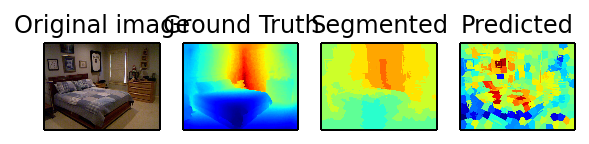

In [20]:
[images, depths] = load_dataset('train/nyu_depth_v2_labeled.mat')

images[1].shape

img_ind = 920 #920# 600 #1337
n_pix = 300

[segs, masks, segment_depths] = preprocess_image(images[img_ind], no_superpixels=n_pix, x_window_size=83,y_window_size=83,
                                                 depth_bins=16, depth_min = 0.7, depth_max=10,true_depth=depths[img_ind])

#predicted, distances = DP2.predict(images[img_ind], no_superpixels=n_pix)
predicted, predictions, segs, mask = DP.predict(images[img_ind], no_superpixels=n_pix, graphcut=False)
# scale_labels = np.logspace(np.log(0.7), np.log(10), num=17, base=np.e)
# print (scale_labels)

# print predicted
#plt.rcParams['savefig.dpi'] = 2 * plt.rcParams['savefig.dpi']
# Ground Truth, segmented + quantized
depth_image = apply_depths(segment_depths, masks)

plt.subplot(151)
plt.imshow(images[img_ind].transpose(2,1,0))
plt.title('Original image')
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#plt.show()
plt.subplot(152)
plt.imshow(depths[img_ind].transpose(1,0))
plt.title('Ground Truth')
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

#plt.colorbar()
#plt.show()
plt.subplot(153)
plt.imshow(depth_image.transpose(1,0))
plt.clim(1,16)
#plt.colorbar()
plt.title('Segmented')
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#plt.show()

# vis_square(segs.transpose(0,2,3,1))
# plt.show()
plt.subplot(154)
#plt.imshow((real_world_values(predicted.transpose(1,0),0.7,10,16)))
plt.imshow(predicted.transpose(1,0))

#plt.colorbar()

plt.title('Predicted')

frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

plt.show()


# # Calculate error metrics:
# abs_err = np.abs(depth_image - predicted)
# errsum = np.linalg.norm(depth_image.ravel() - predicted.ravel())/np.product(err.shape)
# print errsum
# plt.imshow(abs_err.transpose(1,0))
# plt.clim(1,16)
# #print depth_image
# #print predicted


(1, 4096, 1, 1)
[[1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 [1 1 1 ..., 1 1 1]
 ..., 
 [1 1 1 ..., 9 9 9]
 [1 1 1 ..., 9 9 9]
 [1 1 1 ..., 9 9 9]]


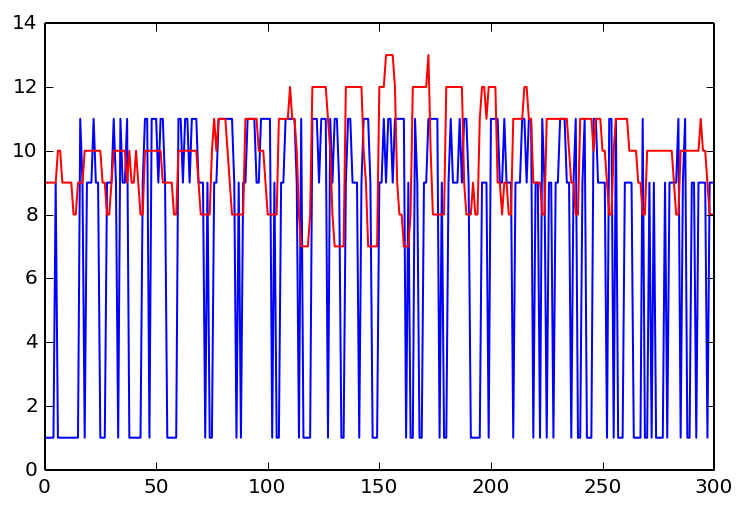

In [127]:
print DP.unaryCNN.blobs['fc6'].data.shape
print predicted
#plt.subplot(211)
plt.plot((np.argmax(predictions,axis=1)),'b')
plt.hold
#plt.subplot(212)
plt.plot(segment_depths,'r-')

In [11]:
# Attempt Graphcut
from gco_python import pygco
from image_handling import pairwise_distance_matrices
   
distances = pairwise_distance_matrices(segs,mask=mask)
         

dist1 = distances[1,:,:]

pairwise_costs = np.round(dist1)
#pairwise_costs = np.eye(16)
print "out keys: ",out.keys()





# unary_costs = np.zeros([1,predictions.shape[0],predictions.shape[1]])
# unary_costs[0,:] = predictions
# print unary_costs.shape
# print "starting graphcut..."
# self.gc_preds = pygco.cut_simple_vh(unary_costs.astype('int32'), 
#                np.eye(16).astype('int32'),
#                pairwise_costs.astype('int32'),
#                pairwise_costs.astype('int32'),
#                n_iter=10, algorithm='swap')
# print self.gc_preds.shape



out keys: 

NameError: name 'out' is not defined

In [219]:
# generate dataset with three stripes
np.random.seed(15)
x = np.zeros((10, 12, 3))
x[:, :4, 0] = -1
x[:, 4:8, 1] = -1
x[:, 8:, 2] = -1
unaries = x + 1.5 * np.random.normal(size=x.shape)
x = np.argmin(x, axis=2)
unaries = (unaries * 10).astype(np.int32)
x_thresh = np.argmin(unaries, axis=2)

# potts potential
pairwise_potts = -2 * np.eye(4, dtype=np.int32)
print unaries.shape
print pairwise_potts.shape
result = pygco.cut_simple_vh(unaries, 10 * pairwise_potts, 1,1)
# potential that penalizes 0-1 and 1-2 less thann 0-2
pairwise_1d = -15 * np.eye(3, dtype=np.int32) - 8
pairwise_1d[-1, 0] = 0
pairwise_1d[0, -1] = 0
print(pairwise_1d)
result_1d = pygco.cut_simple(unaries, pairwise_1d)
plt.subplot(141, title="original")
plt.imshow(x, interpolation="nearest")
plt.subplot(142, title="thresholded unaries")
plt.imshow(x_thresh, interpolation="nearest")
plt.subplot(143, title="potts potentials")
plt.imshow(result, interpolation="nearest")
plt.subplot(144, title="1d topology potentials")
plt.imshow(result_1d, interpolation="nearest")
plt.show()

(10, 12, 3)
(4, 4)


TypeError: Argument 'costV' has incorrect type (expected numpy.ndarray, got int)

[('conv1', (96, 3, 11, 11)), ('conv2', (256, 48, 5, 5)), ('conv3', (384, 256, 3, 3)), ('conv4', (384, 192, 3, 3)), ('conv5', (256, 192, 3, 3)), ('fc6', (1, 1, 4096, 9216)), ('fc7', (1, 1, 4096, 4096)), ('fc_n1', (1, 1, 128, 4096)), ('fc_n2', (1, 1, 16, 128)), ('output_neuron', (1, 1, 1, 16))]


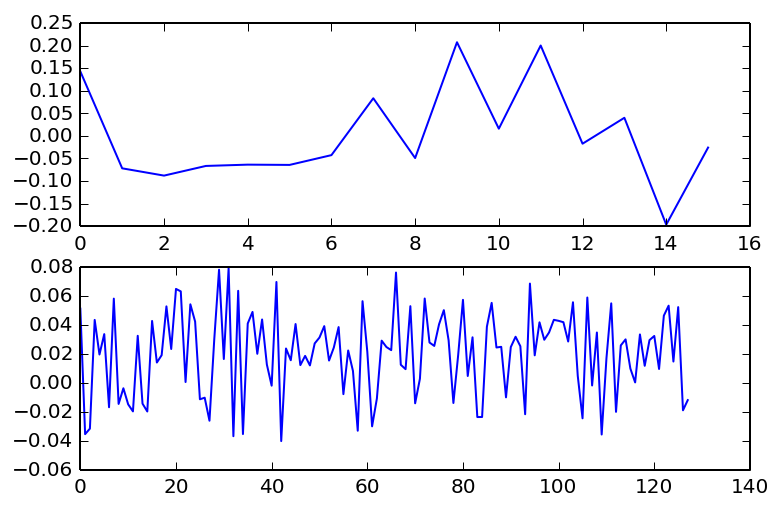

In [94]:
#print DP.unaryCNN.blobs.keys()
#plt.plot(DP.unaryCNN.blobs['fc_n3'].data[0,:,0,0])

plt.subplot(211)
plt.plot(DP.unaryCNN.blobs['fc_n2'].data.ravel())
#print DP.unaryCNN.params['fc_n2']
plt.subplot(212)
print[(k, v[0].data.shape) for k, v in DP.unaryCNN.params.items()]
#print DP.unaryCNN.params['fc_n2'][0].data[0,0,0,:]
plt.plot(DP.unaryCNN.params['fc_n2'][0].data[0,0,0,:])
 

Img Ind is:  312
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.590935580026


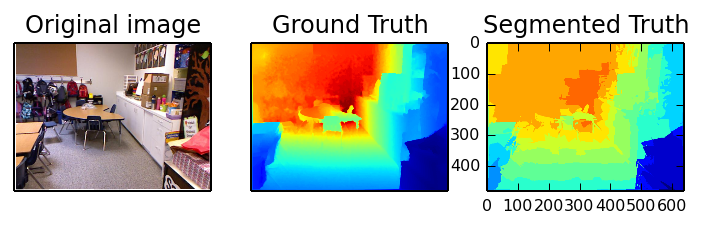

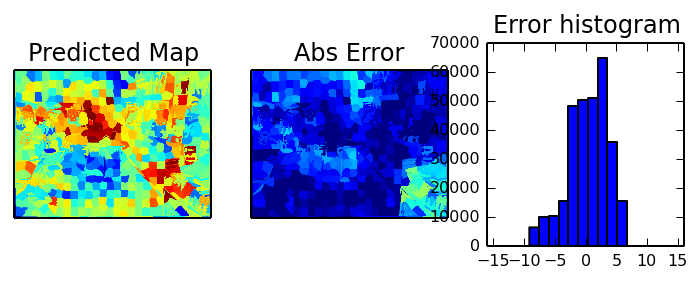

Img Ind is:  28
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.548656152972


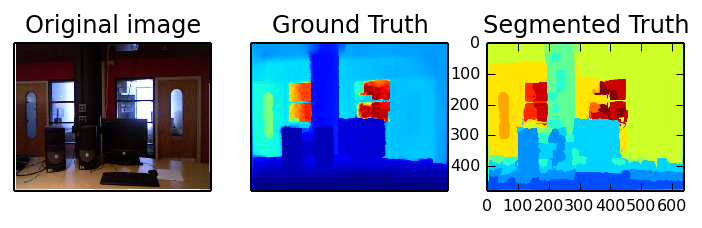

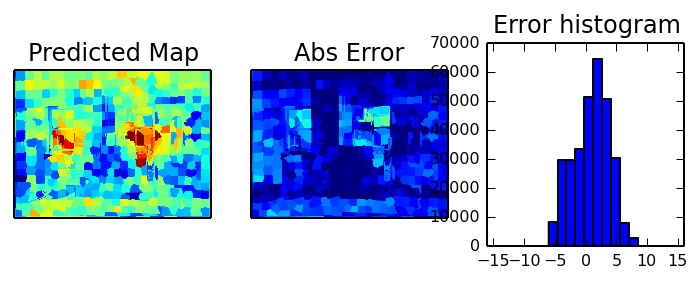

Img Ind is:  332
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.670179848272


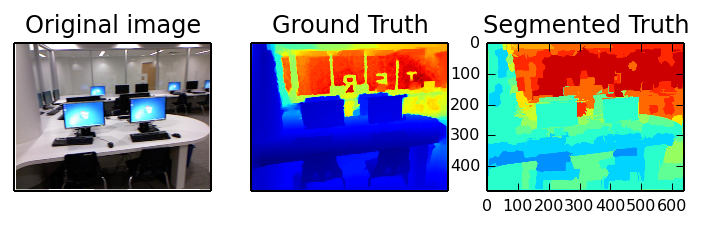

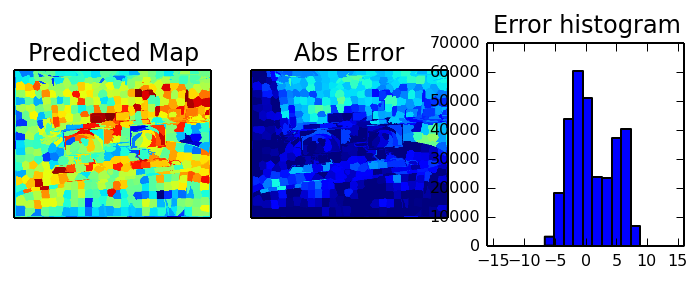

Img Ind is:  472
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.379132799851


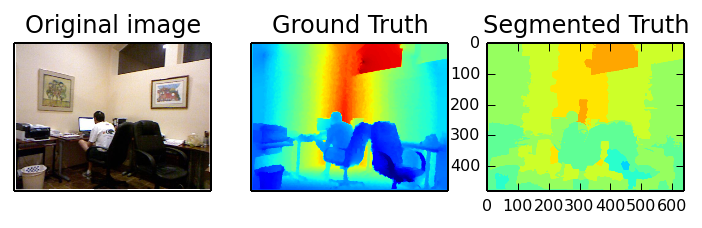

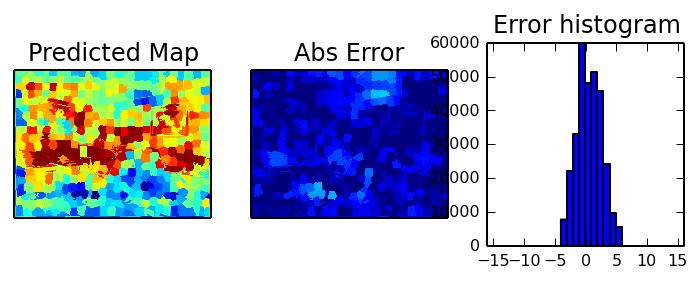

Img Ind is:  362
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.541410727084


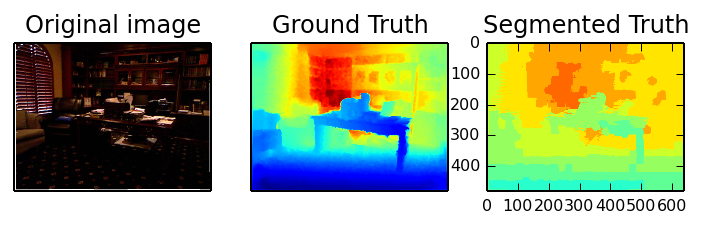

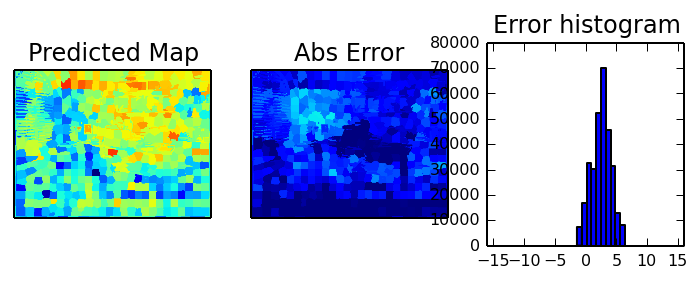

Img Ind is:  1181
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.400297812361


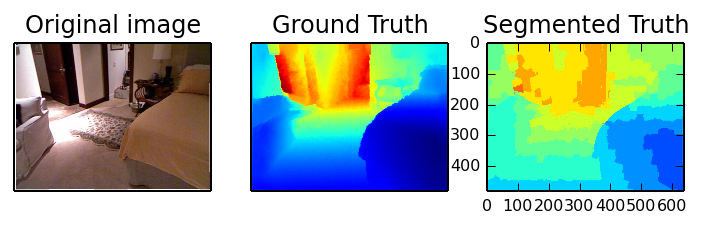

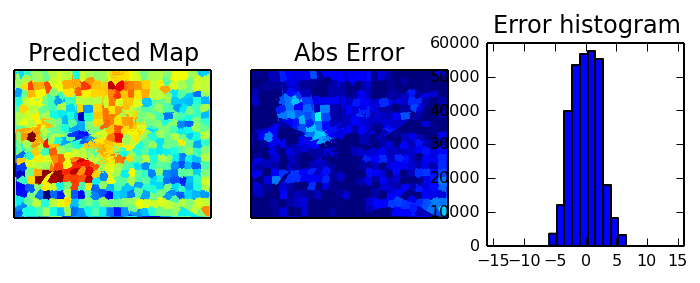

Img Ind is:  581
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.428448110181


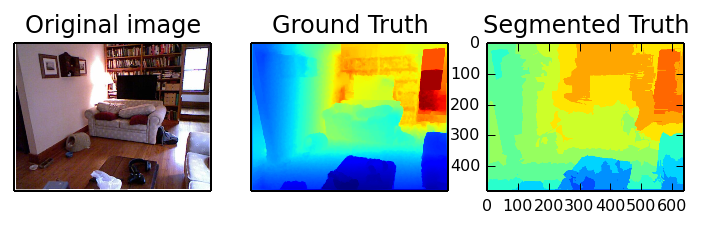

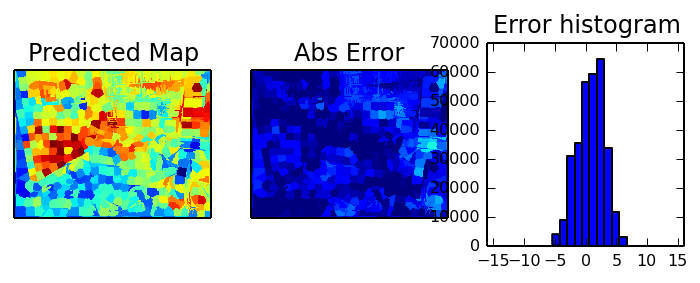

Img Ind is:  1004
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.313306761442


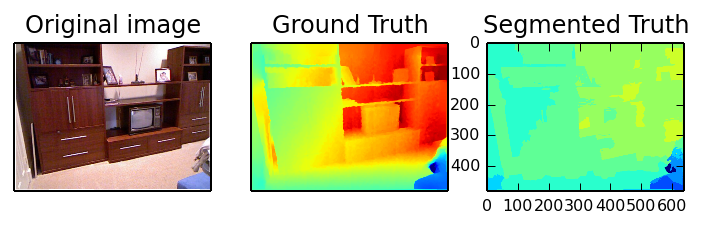

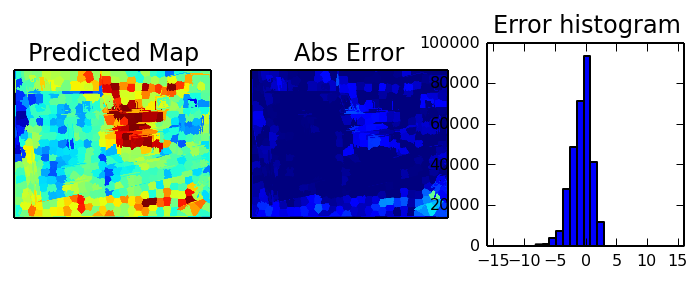

Img Ind is:  1090
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.352590553166


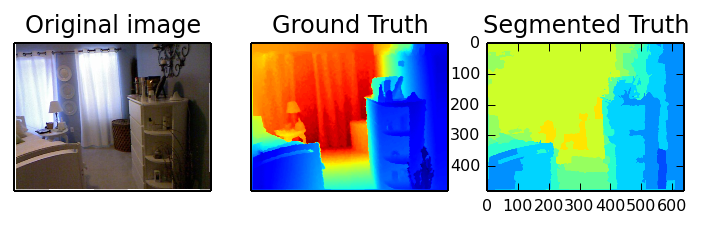

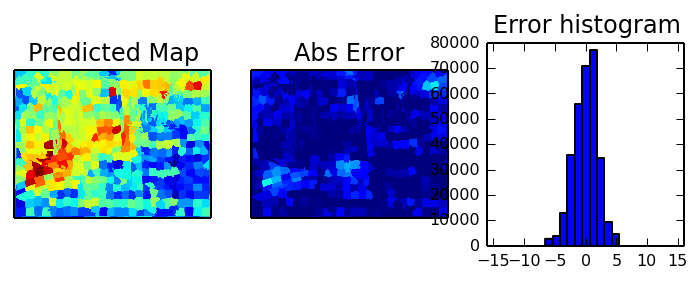

Img Ind is:  118
image dims:  (227, 227)
seg length =  588
RMS percent error =  0.789322254156


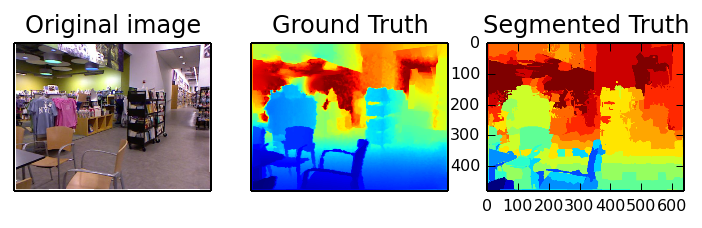

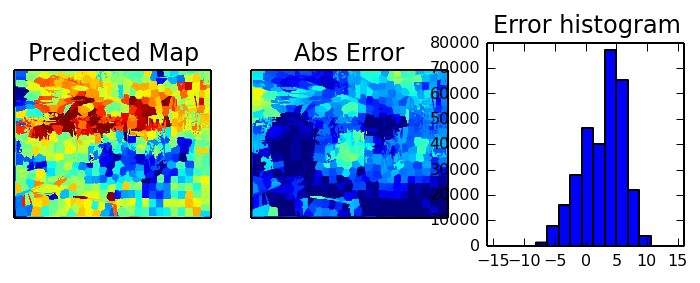

In [56]:
# Loop through a set of random examples from the test split
# Plot figures all pretty-like.
import scipy.io
[images, depths] = load_dataset('train/nyu_depth_v2_labeled.mat')
tmp = scipy.io.loadmat('train/NYUv2/splits.mat')
splits=tmp['testNdxs']
#mean = scipy.io.loadmat('train/NYUv2/splits.mat')
meanfile = 'train/NYUv2/Mean.jpg'
setmean = caffe.io.load_image(meanfile)
prefile = 'models/unary_depth_regressor/snapshots_euclidean/udr_euclidean_d16_superpixel_avg_hardcoded_output_layer_iter_20000.caffemodel'

#modfile = 'models/unary_depth_regressor/udr_euclidean_no_softmax_deploy.prototxt'
modfile = 'models/unary_depth_regressor/udr_euclidean_deploy.prototxt'

total_predicts = []
total_truths = []

DP = DepthPredictor()
DP.load(model_file=modfile, pretrained_file=prefile, meanfile=setmean)

for ii in np.random.choice(range(0,len(splits)),10):
    img_ind = int(splits[ii])
    print "Img Ind is: ",img_ind
#img_ind = 920# 600 #1337
    n_pix = 600

    [segs, masks, segment_depths] = preprocess_image(images[img_ind], no_superpixels=n_pix, x_window_size=83,y_window_size=83,
                                                 depth_bins=16, depth_min = 0.7, depth_max=10,true_depth=depths[img_ind])

    # GUESS IT
    predicted, _, _, _ = DP.predict(images[img_ind], no_superpixels=n_pix)
    
    #print predicted
    # PLOT IT
    # Ground Truth, segmented + quantized
    depth_image = apply_depths(segment_depths, masks)

    rmserr = np.linalg.norm(depth_image.ravel() - predicted.ravel())/np.product(predicted.shape)
    print "RMS percent error = ", 100*rmserr

    total_predicts.append(predicted.ravel())
    total_truths.append(depth_image.ravel())
    plt.subplot(231)
    plt.imshow(images[img_ind].transpose(2,1,0))
    plt.title('Original image')
    frame=plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    #plt.show()
    plt.subplot(232)
    plt.imshow(depths[img_ind].transpose(1,0))
    plt.title('Ground Truth')
    frame=plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)

    #plt.colorbar()
    #plt.show()
    plt.subplot(233)
    plt.imshow(depth_image.transpose(1,0))
    plt.clim(1,16)
    #plt.colorbar()
    plt.title('Segmented Truth')
    plt.show()
    plt.show()
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


    # vis_square(segs.transpose(0,2,3,1))
    # plt.show()
    plt.subplot(234)
    plt.imshow((predicted.transpose(1,0)))
    #plt.colorbar()

    plt.title('Predicted Map')

    frame=plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)


    plt.subplot(235)
    plt.title('Abs Error')
    abs_err = np.abs(depth_image - predicted)
    plt.imshow(abs_err.transpose(1,0))
    plt.clim(1,16)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
 #   plt.show()
    
    plt.subplot(236)
    plt.hist((depth_image.ravel() - predicted.ravel()))
    plt.xlim(-16,16)
    plt.title('Error histogram')
    frame = plt.gca()
    #frame.axes.get_xaxis().set_visible(False)
    #frame.axes.get_yaxis().set_visible(False)
    plt.show()
    
    
    plt.savefig('Predicted_pngs/predicted'+ str(img_ind) +'.png')

    rmserr = np.linalg.norm(depth_image.ravel() - predicted.ravel())/np.product(predicted.shape)


# Calculate error metrics:
# abs_err = np.abs(depth_image - predicted)
# errsum = np.linalg.norm(depth_image.ravel() - predicted.ravel())/np.product(err.shape)
# print errsum
# plt.imshow(abs_err.transpose(1,0))
# plt.clim(1,16)
#print depth_image
#print predicted

    
    
    

    
    
    


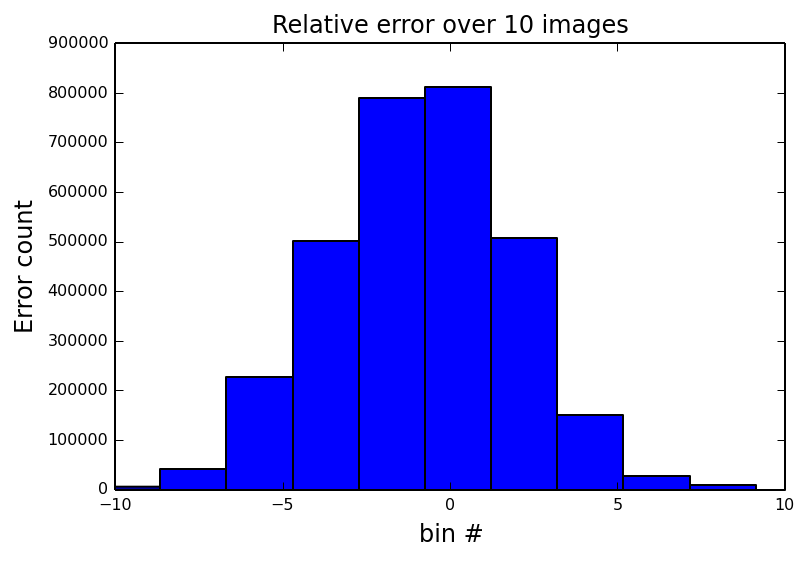

In [57]:
errz = np.array(total_predicts).ravel() - np.array(total_truths).ravel()

#plt.plot(np.array(total_predicts).ravel())
#plt.plot(16 - np.array(total_truths).ravel())
plt.hist(errz)
plt.xlim(-10,10)
plt.xlabel('bin #')
plt.ylabel('Error count')
plt.title('Relative error over 10 images')
plt.savefig('Error_histogram.pdf')

In [15]:
# Display all 3 depth-averaging modes (Log and linear scales)

[images, depths] = load_dataset('train/nyu_depth_v2_labeled.mat')

#images[1].shape

img_ind = 273# 273 #334 #920# 600 #1337
n_pix = 600
depth_min = 0.7;
depth_max = 10;
depth_bins = 16;

[segs, masks, segment_depths] = preprocess_image(images[img_ind], no_superpixels=n_pix, x_window_size=83,y_window_size=83,
                                                 depth_bins=depth_bins, depth_min = depth_min, depth_max=depth_max,true_depth=depths[img_ind],
                                                 depth_type=0)
depth_image = apply_depths(segment_depths, masks)

[segs1, masks1, segment_depths1] = preprocess_image(images[img_ind], no_superpixels=n_pix, x_window_size=83,y_window_size=83,
                                                 depth_bins=depth_bins, depth_min = depth_min, depth_max=depth_max,true_depth=depths[img_ind],
                                                 depth_type=1)
depth_image_1 = apply_depths(segment_depths1, masks1)
[segs2, masks2, segment_depths2] = preprocess_image(images[img_ind], no_superpixels=n_pix, x_window_size=83,y_window_size=83,
                                                 depth_bins=depth_bins, depth_min = depth_min, depth_max=depth_max,true_depth=depths[img_ind],
                                                 depth_type=2)
depth_image_2 = apply_depths(segment_depths2, masks2)
#plt.colorbar()
#plt.show()
plt.subplot(231)
plt.imshow(depth_image.transpose(1,0))
plt.clim(1,16)
#plt.colorbar()
plt.title('Center-value Depth',fontsize=10)
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
#frame.axes.get_yaxis().set_visible(False)
plt.ylabel('Log-scaled',fontsize=10)
#plt.show()
plt.subplot(232)
plt.imshow(depth_image_1.transpose(1,0))
plt.clim(1,16)
#plt.colorbar()
plt.title('Superpixel Average',fontsize=10)
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#plt.show()
plt.subplot(233)
plt.imshow(depth_image_2.transpose(1,0))
plt.clim(1,16)
#plt.colorbar()
plt.title('Window Average',fontsize=10)
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#plt.show()
#plt.show()


plt.subplot(234)
plt.imshow(real_world_values(depth_image, depth_min,depth_max,depth_bins).transpose(1,0))
plt.clim(depth_min, depth_max)
#plt.colorbar()
#plt.title('Center-value Depth')
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
#frame.axes.get_yaxis().set_visible(False)
plt.ylabel('Linear-scaled',fontsize=10)
#plt.show()
plt.subplot(235)
plt.imshow(real_world_values(depth_image_1, depth_min,depth_max,depth_bins).transpose(1,0))
plt.clim(depth_min, depth_max)
#plt.colorbar()
#plt.title('Superpixel Average')
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#plt.show()
plt.subplot(236)
plt.imshow(real_world_values(depth_image_2, depth_min,depth_max,depth_bins).transpose(1,0))
plt.clim(depth_min, depth_max)
#plt.colorbar()
#plt.title('Window Average')
frame=plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)
#plt.show()
plt.show()#print np.min(depth_image),np.max(depth_image)
#print np.min(depth_image_2),np.max(depth_image_2)
plt.savefig('depth_scaling.png')
# # Calculate error metrics:
# abs_err = np.abs(depth_image - predicted)
# errsum = np.linalg.norm(depth_image.ravel() - predicted.ravel())/np.product(err.shape)
# print errsum
# plt.imshow(abs_err.transpose(1,0))
# plt.clim(1,16)
# #print depth_image
# #print predicted